# Classification

In this notebook, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied
so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. Whenever someone learns Machine Learning, sooner or
later they tackle MNIST. 

Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them. The following code fetches the MNIST dataset:1

In [2]:
# imports
from sklearn.datasets import load_digits
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist = load_digits()

mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
# main data
X = mnist["data"]

# target array
y = mnist["target"]

print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


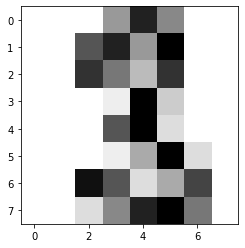

3


In [4]:
import random

# a sample instance
random_num = random.randint(0, 1100)
some_digit = X[random_num]
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
# plt.axis("off")
plt.show()

print(y[random_num])

#### Splitting data

In [5]:
X_train, X_test, y_train, y_test = X[: 1100], X[1100:], y[: 1100], y[1100:]

import numpy as np

shuffle_index = np.random.permutation(1100)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a binary classifier

Simplifying the problem for now and only try to identify one digit—for example, the number 5. This **“5-detector”** will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [6]:
y_train_5 = (y_train == 5)     # True for all 5s; False for all other digits
y_test_5 = (y_test == 5)

# Now our y arrays have only two classes; True and False (5 or not 5)

y_train_5

array([False, False, False, ..., False, False, False])

In [6]:
from sklearn.linear_model import SGDClassifier
"""
The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you
should set the random_state parameter.
"""

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# predict on an instance
sgd_clf.predict([some_digit])

array([False])

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available.

### 1. Measuring Accuracy Using Cross Validation
A good way to evaluate a model is to use cross validation

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.98910082, 0.97820163, 0.99180328])

Wow! Above 96% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? 
Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()

# evaluating dumb classfier with cross-validation
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.88283379, 0.90463215, 0.90710383])

That’s right, it has over 88% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally **not the preferred performance measure for classifiers**, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

Also known as Class Imbalance.

### 2. Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. 
**A confusion matrix is a summary of prediction results on a classification problem**

The general idea is to count the number of times instances of class A are classified as class B. 
For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch. Instead, you can use the cross_val_predict() function:

The function **cross_val_predict** has a similar interface to **cross_val_score**, but returns, for each element in the input, the **prediction that was obtained for that element when it was in the test set**.

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

Each **row** in a confusion matrix represents an **actual class**, while each **column represents a **predicted class**. 

The first row of this matrix considers non-5 images (the negative class): **974** of them were correctly classified as **non-5s** (they are called true negatives), while the **remaining 14 were wrongly classified as 5s** (false positives).

The second row considers the images of 5s (the positive class): 7 were wrongly classified as non-5s (false negatives), while the remaining 105 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[986,   2],
       [ 13,  99]], dtype=int64)

### Precision and Recall

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. 

An interesting one to look at is the accuracy of the positive predictions; This is called the **precision of the classifier**.

*precision = TP / (TP + FP)*

TP is the number of true positives, and FP is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the classifier would ignore all but one positive instance. 

So precision is typically used along with another metric named **recall**, also called **sensitivity** or **true positive rate
(TPR):** this is the ratio of positive instances that are correctly detected by the classifier

*recall = TP / (TP + FN)*

FN is of course the number of false negatives.

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [11]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(f"Precision: {precision} \nRecall: {recall}")

Precision: 0.9801980198019802 
Recall: 0.8839285714285714


When the "5-detector" claims an image represents a 5, it is correct only 94% of the time. Moreover, it only detects 95% of the 5s.

It is often **convenient to combine precision and recall** into a single metric called the **F1 score**, in particular if you need a simple way to **compare two classifiers.** 

The F1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. 

As a result, the classifier will only get a **high F1 score if both recall and precision are high.**

In [13]:
from sklearn.metrics import f1_score

f1_score = f1_score(y_train_5, y_train_pred)
f1_score

0.9295774647887323

### Precision/Recall tradeoff

To understand this tradeoff, let’s look at how the SGDClassifier makes its classification decisions. 

For each instance, it computes a score based on a **decision function,** and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance.

In this case we are using the **cross_val_predict** with the **decision_function** method to get the decision scores that are used to make the predictions instead of the predictions themselves.

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-2360.64554847, -2368.48517217, -2860.70154578, ...,
       -6710.62179168, -1834.42408748, -7602.37779206])

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

The above gives a precision and recall for each threshold in thresholds

Finally, you can plot precision and recall as functions of the threshold value using Matplotlib

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

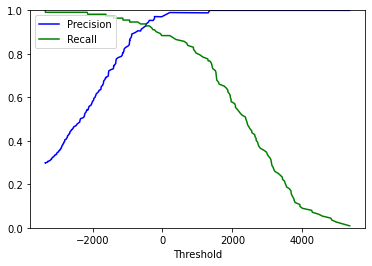

In [31]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. 

Another way to select a good precision/recall tradeoff is to plot **precision directly against recall**

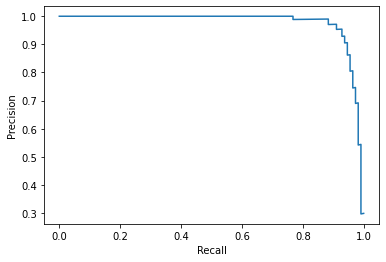

In [35]:
plt.plot(recalls, precisions,)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()